In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [5]:
with open("Doordash.json") as diabetes_dataset:
    dataset = json.load(diabetes_dataset)

In [6]:
def processing_json_dataset(dataset):
    tags = []
    inputs = []
    responses={}
    for intent in dataset['intents']:
        responses[intent['intent']]=intent['responses']
        for lines in intent['text']:
            inputs.append(lines)
            tags.append(intent['intent'])
    return [tags, inputs, responses]

In [7]:
[tags, inputs, responses] = processing_json_dataset(dataset)

In [8]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [9]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [10]:
dataset = dataset.sample(frac=1)

In [11]:
dataset.head()

,inputs,tags
117,My issue is not resolved,More Help
10,Order help,Need Help
95,What is DashPass?,DashPass Inquiry
41,I did not recieve my order?,Missing Order
37,I did not get all my order,Missing or incorrect item


In [12]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [13]:
dataset.head()

,inputs,tags
117,"[m, y, , i, s, s, u, e, , i, s, , n, o, t, ...",More Help
10,"[o, r, d, e, r, , h, e, l, p]",Need Help
95,"[w, h, a, t, , i, s, , d, a, s, h, p, a, s, s]",DashPass Inquiry
41,"[i, , d, i, d, , n, o, t, , r, e, c, i, e, ...",Missing Order
37,"[i, , d, i, d, , n, o, t, , g, e, t, , a, ...",Missing or incorrect item


In [14]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [15]:
dataset.head()

,inputs,tags
117,my issue is not resolved,More Help
10,order help,Need Help
95,what is dashpass,DashPass Inquiry
41,i did not recieve my order,Missing Order
37,i did not get all my order,Missing or incorrect item


In [16]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [17]:
len(features[0])

11

In [18]:
input_shape = features.shape[1]
print(input_shape)

11


In [19]:
features.shape

(146, 11)

In [20]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  199
output length:  28


In [21]:
tokenizer.word_index

{'my': 1,
 'i': 2,
 'order': 3,
 'is': 4,
 'to': 5,
 'not': 6,
 'was': 7,
 'you': 8,
 'want': 9,
 'did': 10,
 'me': 11,
 'can': 12,
 'cancel': 13,
 'do': 14,
 'need': 15,
 'dasher': 16,
 'an': 17,
 'it': 18,
 'food': 19,
 'what': 20,
 'dashpass': 21,
 'the': 22,
 'how': 23,
 'please': 24,
 'more': 25,
 'a': 26,
 'help': 27,
 'get': 28,
 'am': 29,
 'with': 30,
 'something': 31,
 'where': 32,
 'reciept': 33,
 'bella': 34,
 'driver': 35,
 'adam': 36,
 'issue': 37,
 'know': 38,
 'im': 39,
 'service': 40,
 'your': 41,
 'there': 42,
 'made': 43,
 'delivery': 44,
 'account': 45,
 'long': 46,
 'instructions': 47,
 'else': 48,
 'ok': 49,
 'ordered': 50,
 'subscription': 51,
 'recieve': 52,
 'saying': 53,
 'missing': 54,
 'nice': 55,
 'hello': 56,
 'update': 57,
 'fuck': 58,
 'hya': 59,
 'find': 60,
 'about': 61,
 'and': 62,
 'damaged': 63,
 'but': 64,
 'anymore': 65,
 'bad': 66,
 'verify': 67,
 'for': 68,
 'address': 69,
 'still': 70,
 'have': 71,
 'charged': 72,
 'taking': 73,
 'so': 74,
 'the

In [22]:
m = Sequential()
m.add(Input(shape=(features.shape[1])))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [23]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-12-01 16:59:12--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-01 16:59:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 40s  

2022-12-01 17:01:53 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [24]:
m.layers

In [25]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [26]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [29]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [30]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 100)           20000     
                                                                 
 conv1d (Conv1D)             (None, 7, 32)             16032     
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 7, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [31]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [32]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])


Epoch 1/2000
3/3 [==============================] - 5s 19ms/step - loss: 3.3405 - accuracy: 0.0548
Epoch 2/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.3381 - accuracy: 0.0548
Epoch 3/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.3413 - accuracy: 0.0342
Epoch 4/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.3339 - accuracy: 0.0411
Epoch 5/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.3315 - accuracy: 0.0685
Epoch 6/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.3273 - accuracy: 0.1096
Epoch 7/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.3259 - accuracy: 0.0411
Epoch 8/2000
3/3 [==============================] - 0s 17ms/step - loss: 3.3236 - accuracy: 0.0822
Epoch 9/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.3078 - accuracy: 0.0890
Epoch 10/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.3075 - accuracy: 0.0685
Epoch 11/

In [33]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

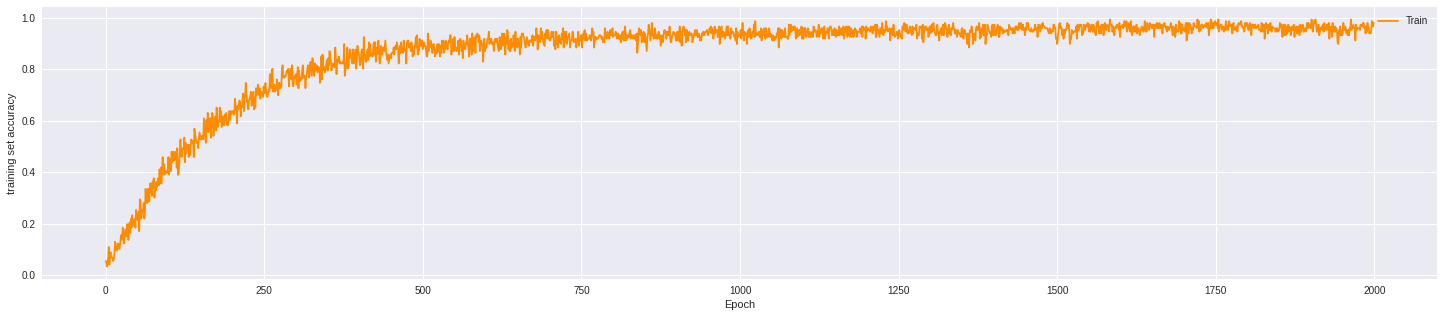

In [34]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

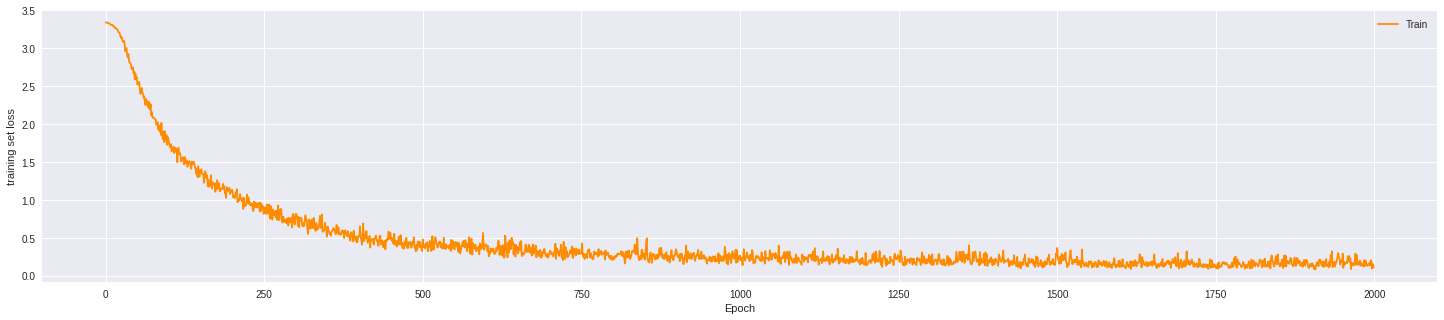

In [35]:
draw_plot(history_training.history['loss'],'training set loss' )

In [36]:
m.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 7ms/step - loss: 0.0490 - accuracy: 0.9932


[0.04904390871524811, 0.9931507110595703]

In [37]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])


In [38]:
list_que = ["fuck you", "I need help","My dasher is so rude", "cancel my order"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print("Gabriel:",res_tag)  

you: fuck you
1/1 [==============================] - 1s 945ms/step
Gabriel: I will be happy to help you without the swearing
you: I need help
1/1 [==============================] - 0s 19ms/step
Gabriel: Thanks for chatting with me today. I see you are still having an issue. A Customer Care specielist will be in contact with you shortly
you: My dasher is so rude
1/1 [==============================] - 0s 21ms/step
Gabriel: I understand your frustration with the service you have recieved. This isn't the experience we want for you. I will be taking the appropriate actions for feedback on the dasher.
you: cancel my order
1/1 [==============================] - 0s 19ms/step
Gabriel: Orders may be cancelled for a variety of reasons, such as: restaurant is closed, restaurant is out of an item, restaurant is no longer accepting takeout orders. While we never want a situation where your order is cancelled by a party other than you, if it is, we will ensure you receive a full credit or refund.


In [39]:
m.save("chatbotmodel1.h5", history_training)